# Calculating the Radius from transit depth

You Belong With Me
****

Importing Modules

In [37]:
import astropy.constants as const
import Gridingtons as grid
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
from pylab import arange,pi,sin,cos,sqrt
import scipy.stats as stats
import seaborn as sns
from WhatisLife import Rotator

In [2]:
%matplotlib notebook
π = np.pi
Colour = plt.style.use('tableau-colorblind10')

In [3]:
def ScreamExtractor(File, Sep=','):
    FILENAME = pd.read_csv(f'{File}', sep=Sep)
    return FILENAME

In [4]:
Directory = 'C:/Users/georg/Documents/GitHub/Iwan-and-George-Year-4-Project'
PlanetData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Planets/Final Planets.csv').dropna(ignore_index=True)
GaiaDatat = ScreamExtractor(f'{Directory}/BASTA/Input/Gaia.txt', '\t').dropna(ignore_index=True)
GaiaData2t = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/Gaia All Stars.csv').dropna(ignore_index=True)
BASTAData = ScreamExtractor(f'{Directory}/BASTA/Output/GaiaResultsFinal.ascii', '\t').dropna(ignore_index=True)
FultonData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/Fulton All Stars.csv').dropna(ignore_index=True)
VanEylenData = ScreamExtractor(f'{Directory}/Samples/Sorted Data/Stars/VanEylen All Stars.csv').dropna(ignore_index=True)
HRData = ScreamExtractor(f'{Directory}/Samples/Raw Data/HR Data.csv').dropna(ignore_index=True)

In [5]:
FultonData = pd.concat([FultonData, VanEylenData], ignore_index=True)

In [6]:
GaiaData = pd.DataFrame()
GaiaData2 = pd.DataFrame()
for g in range(len(BASTAData)):
    try:
        Line = GaiaDatat[GaiaDatat['# ID'] == BASTAData['starid'][g]]
        GaiaData = pd.concat([GaiaData, Line], ignore_index=True)
    except:
        continue

    try:
        Line = GaiaData2t[GaiaData2t['Gaia DR3 ID'] == BASTAData['starid'][g]]
        GaiaData2 = pd.concat([GaiaData2, Line], ignore_index=True)
    except:
        continue
del GaiaDatat, GaiaData2t

In [ ]:
def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

In [ ]:
def PlanetRadiusFinder(Planets, Stars, BASTAfication='Post'):
    if BASTAfication == 'Pre':
        ID = 'Gaia DR3 ID'
        Radii = 'Radius'
        Radiierrp = 'Rad pe'
        Radiierrm = 'Rad me'
    else:
        ID = 'starid'
        Radii = 'radPhot'
        Radiierrp = 'radPhot_errp'
        Radiierrm = 'radPhot_errm'
    
    Period = []
    PlanetRadius = []
    PlanetRadiuserrp = []
    PlanetRadiuserrm = []
    for n in range(len(Planets)):
        try:
            Index = Stars[Stars[ID] == Planets['Host Gaia DR3 ID'][n]].index[0]
            Radius = Planets['PSR'][n]*Stars[Radii][Index]*const.R_sun/const.R_earth
            if Radius < 4:
                Period.append(Planets['P'][n])
                PlanetRadius.append(Radius)

                PlanetRadiuserrp.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrp][Index]))
                PlanetRadiuserrm.append(PlanetRadiusErrors(Planets['PSR'][n], Stars[Radii][Index],
                                                           Planets['PSR pme'][n], Stars[Radiierrm][Index]))
        except:
            continue
    return Period, PlanetRadius, [PlanetRadiuserrp, PlanetRadiuserrm]

In [ ]:
PeriodBASTA, RadiusBASTA, RadiusBASTAerr = PlanetRadiusFinder(PlanetData, BASTAData)
PeriodGaia, RadiusGaia, RadiusGaiaerr = PlanetRadiusFinder(PlanetData, GaiaData2, 'Pre')

In [ ]:
def Gradienter(XAxis, YAxis, m, X=10):
    NewX = np.linspace(10, 10, len(XAxis))
    NewY = 10**(m*(X-XAxis)+YAxis)
    return NewX, NewY

In [ ]:
Title = 'Radius Valley plot for Gaia Stars and VanHo Planets'
'''
plt.figure()
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr,
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia)')
plt.xscale('log')
plt.xlabel('log(Orbital Period/Days)', fontsize=12)
plt.ylabel('$R/R_{\oplus}$', fontsize=12)
plt.title(Title, fontsize=15)
plt.legend()
plt.show()
'''
#sns.jointplot(x=np.log10(PeriodGaia), y=np.array(RadiusGaia), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
sns.jointplot(x=np.log10(PeriodBASTA), y=np.array(RadiusBASTA), joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
plt.show()

In [ ]:
Centre = [(min(PeriodBASTA)+max(PeriodBASTA))/2,(min(RadiusBASTA)+max(RadiusBASTA))/2]
Angles = π/400
#Rotator(PeriodBASTA, RadiusBASTA, Centre, Angles)

In [ ]:
x = np.linspace(min(PeriodBASTA), max(PeriodBASTA), 2)
m = -0.11
c1 = 0.37
y1 = 10**(m*np.log10(x) + c1)

In [ ]:
np.median(RadiusBASTAerr)

In [24]:
Title='Radius Valley for exoplanets from HoVan and stellar data from Gaia'

plt.figure()
plt.errorbar(PeriodGaia, RadiusGaia, yerr=RadiusGaiaerr, elinewidth=0.5,
             capsize=0.5, fmt='.', color=Colour, markersize=2, label='Pre BASTA')
plt.errorbar(PeriodBASTA, RadiusBASTA, yerr=RadiusBASTAerr, elinewidth=0.5,
             capsize=0.5, fmt='.', color=Colour, markersize=2, label='Post BASTA')
plt.plot(x, y1, color=Colour, label='Radius Valley (VanHo)')
plt.xlabel('Orbital Period (days)', fontsize=12)
plt.ylabel(r'$R_p/R_{\oplus}$', fontsize=12)
plt.title(Title, fontsize=12)
plt.xscale('log')
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/Final Stars - {Title}')

<IPython.core.display.Javascript object>

NameError: name 'PeriodGaia' is not defined

In [7]:
SolarTemp = 5772
def LuminosityErrors(Radius, Teff, RadiusError, TeffError):
    Error = 2*Radius*Teff**3/SolarTemp**4*np.sqrt(Teff**2*RadiusError**2 + 4*Radius**2*TeffError**2)
    return Error

In [8]:
GaiaData2['Rad pe'] += 0.027*GaiaData2['Radius']
GaiaData2['Rad me'] += 0.027*GaiaData2['Radius']
GaiaData2['Teff pe'] = np.sqrt(GaiaData2['Teff pe']**2 + 102**2)
GaiaData2['Teff me'] = np.sqrt(GaiaData2['Teff me']**2 + 102**2)

In [9]:
LuminosityGaia = GaiaData2['Radius']**2*(GaiaData2['Teff']/SolarTemp)**4
LuminosityBASTA = BASTAData['radPhot']**2*(BASTAData['Teff']/SolarTemp)**4
LuminosityFulton = FultonData['Radius']**2*(FultonData['Teff']/SolarTemp)**4
LuminosityGaiaerrp = LuminosityErrors(GaiaData2['Radius'], GaiaData2['Teff'], 
                                       GaiaData2['Rad pe'], GaiaData2['Teff pe'])
LuminosityGaiaerrm = LuminosityErrors(GaiaData2['Radius'], GaiaData2['Teff'], 
                                       GaiaData2['Rad me'], GaiaData2['Teff me'])
LuminosityBASTAerrp = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errp'], BASTAData['Teff_errp'])
LuminosityBASTAerrm = LuminosityErrors(BASTAData['radPhot'], BASTAData['Teff'], 
                                       BASTAData['radPhot_errm'], BASTAData['Teff_errm'])
LuminosityFultonerrp = LuminosityErrors(FultonData['Radius'], FultonData['Teff'], 
                                       FultonData['Rad pe'], FultonData['Teff pe'])
LuminosityFultonerrm = LuminosityErrors(FultonData['Radius'], FultonData['Teff'], 
                                       FultonData['Rad me'], FultonData['Teff me'])

In [26]:
#!python numbers=disable
# 500.484 for single 0.8 scale
# 240.23016 for doublen 0.48 scale
fig_width_pt = 240.23016  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]


<IPython.core.display.Javascript object>


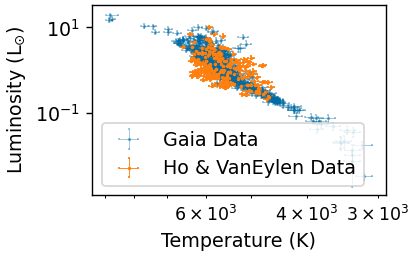

In [39]:
Title = 'HR Diagram showing the different Samples'

fig = plt.figure(constrained_layout=True)
fig.set_size_inches(*figsize)
plt.errorbar(GaiaData2['Teff'], LuminosityGaia, xerr=[GaiaData2['Teff pe'], GaiaData2['Teff me']],
             yerr=[LuminosityGaiaerrp, LuminosityGaiaerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.4)
plt.errorbar(FultonData['Teff'], LuminosityFulton, xerr=[FultonData['Teff pe'], FultonData['Teff me']],
             yerr=[LuminosityFultonerrp, LuminosityFultonerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='Ho & VanEylen Data', alpha=1)
'''plt.errorbar(BASTAData['Teff'], LuminosityBASTA, xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[LuminosityBASTAerrp, LuminosityBASTAerrm], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)'''
#plt.plot(HRData['Teff'], HRData['Luminosity'], '.', color=Colour, markersize=0.1, label='Background')
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=11)
plt.ylabel('Luminosity (L$_{\odot}$)', fontsize=11)
plt.tick_params(labelsize=11)
#plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
#plt.ylim(0.01, 30)
plt.legend(fontsize=11)
plt.show()
plt.savefig(f'{Directory}/Plots/Report Plots/{Title}.pdf')

In [ ]:
Title = 'HR Diagram showing Radius before and after BASTA'

plt.figure()
plt.errorbar(GaiaData2['Teff'], GaiaData2['Radius'], xerr=GaiaData['Teff-err'],
             yerr=[GaiaData2['Rad pe']+0.035/GaiaData2['Radius'], GaiaData2['Rad me']+0.035/GaiaData2['Radius']],
             fmt='.', color=Colour, elinewidth=0.5, capsize=0.5, markersize=2, label='Gaia Data', alpha=0.4)
plt.errorbar(BASTAData['Teff'], BASTAData['radPhot'], xerr=[BASTAData['Teff_errp'], BASTAData['Teff_errm']],
             yerr=[BASTAData['radPhot_errp'], BASTAData['radPhot_errm']], fmt='.', color=Colour,
             elinewidth=0.5, capsize=0.5, markersize=2, label='BASTA (Gaia) Data', alpha=1)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Radius (R$_{\odot}$)', fontsize=12)
plt.title(Title, fontsize=15)
#plt.xlim(8000, 4000)
plt.ylim(0.2, 5)
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All - {Title}')

In [ ]:
np.median(PercentageError1.dropna())

In [ ]:
PercentageError1 = (GaiaData2['Rad pe']+GaiaData2['Rad me'])/2/GaiaData2['Radius']*100+3.5
PercentageError2 = (BASTAData['radPhot_errp']+BASTAData['radPhot_errm'])/2/BASTAData['radPhot']*100
Median1 = np.median(PercentageError1.dropna())
Median2 = np.median(PercentageError2)

Title = r'KDE of % Uncertainty in Radius before and after BASTA'
plt.figure()
ax = sns.kdeplot(data=PercentageError1, label='Pre BASTA')
sns.kdeplot(data=PercentageError2, label='Post BASTA')
ax.axvline(Median1, color='blue', linestyle='--', label=f'Pre-Median: {np.round(Median1, 2)}')
ax.axvline(Median2, color='orange', linestyle='--', label=f'Post-Median: {np.round(Median2, 2)}')
plt.xlabel(r'% Uncertainty in Radius')
plt.title(Title)
plt.xlim(0, 15)
plt.legend()
plt.show()
#plt.savefig(f'{Directory}/Plots/Old Plots/Money Plots/Final Stars - {Title}')

In [ ]:
Title = r'KDE of Radius before and after BASTA '
plt.figure()
ax = sns.kdeplot(data=GaiaData2['Radius'], label='Pre BASTA')
sns.kdeplot(data=BASTAData['radPhot'], label='Post BASTA')
plt.xlabel(r'Radius')
plt.title(Title)
plt.legend()
plt.xlim(0, 5)
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All Stars - {Title}')

In [ ]:
Title = 'Radius % Uncertainty change'

plt.figure()
plt.plot(BASTAData['radPhot'], PercentageError2, '.', markersize=2)
plt.xlabel('Radius (R$_{\odot}$)')
plt.ylabel('% Uncertainty in Radius')
plt.title(Title)
plt.ylim(0, 20)
plt.show()
#plt.savefig(f'{Directory}/Plots/Money Plots/All Stars - {Title}')

You tatty git